Решить задачу регрессии - предсказать цены на недвижимость.
* Использовать датасет www.kaggle.com...iques/data (train.csv)
* Построить случайный лес, вывести важность признаков
* Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [1]:
# импорт необходимых библиотек и настройка параметров визуализации
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels as stats

parameters = {
    'axes.labelsize':  14,
    'figure.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
}
plt.rcParams.update(parameters)

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [2]:
# чтение и подготовка данных
# удаление всех столбцов с пропусками и всех не численных столбцов
df = pd.read_csv('train.csv')
df.dropna(axis=1, inplace=True)
df = df.select_dtypes(exclude=['object'])

y = df['SalePrice']
del df['SalePrice']
X = df
X.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,8450,7,5,2003,2003,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
1,2,20,9600,6,8,1976,1976,978,0,284,...,460,298,0,0,0,0,0,0,5,2007
2,3,60,11250,7,5,2001,2002,486,0,434,...,608,0,42,0,0,0,0,0,9,2008
3,4,70,9550,7,5,1915,1970,216,0,540,...,642,0,35,272,0,0,0,0,2,2006
4,5,60,14260,8,5,2000,2000,655,0,490,...,836,192,84,0,0,0,0,0,12,2008


In [3]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [4]:
# разбивка на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Случайный лес

In [5]:
# обучение случайного леса
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

In [6]:
# оценка точности предсказания
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(rf_predict, y_test))

30527.04660248734

Feature ranking:


(-1.0, 10.0)

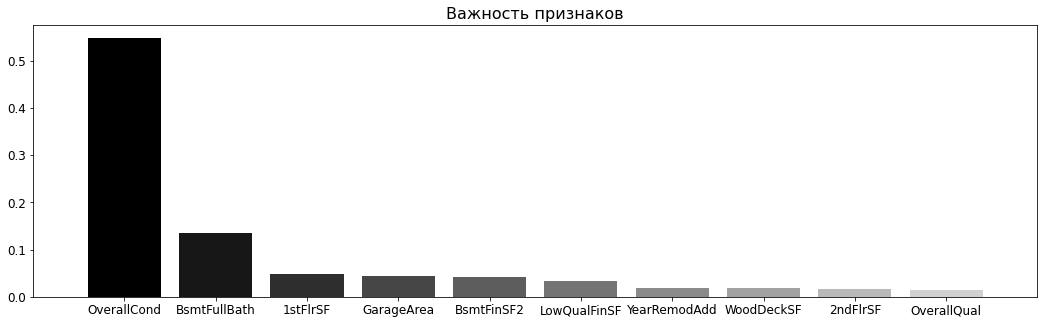

In [7]:
# from https://habr.com/ru/company/ods/blog/324402/
importances  = rf.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

plt.figure(figsize=(18,5))
plt.title(u"Важность признаков")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   X.columns[feature_indices])
plt.xlim([-1, num_to_plot])

### Стекинг

In [8]:
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [9]:
regressor = StackingRegressor(
    [
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('svr', SVR())
    ],
RandomForestRegressor())

In [10]:
regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('dt', DecisionTreeRegressor()), ('svr', SVR())],
                  final_estimator=RandomForestRegressor())

In [11]:
np.sqrt(mean_squared_error(regressor.predict(X_test), y_test))

32919.28864732828

Качество стекинга получилось на 9% лучше, качества случайного леса